# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.squeeze(image)
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  #tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=4,
    validation_data=ds_test,
)

Epoch 1/4
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.9154
Epoch 2/4
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.2392 - val_sparse_categorical_accuracy: 0.9307
Epoch 3/4
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9344 - val_loss: 0.2019 - val_sparse_categorical_accuracy: 0.9425
Epoch 4/4
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.1752 - val_sparse_categorical_accuracy: 0.9492


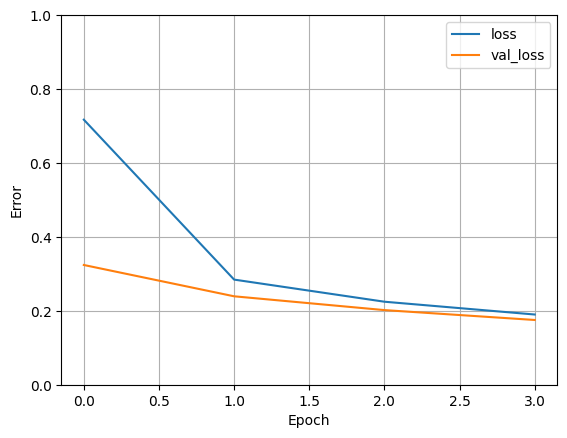

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist

# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

# Plot the training history (similar to the MNIST example)
# ... (Use the plot_loss function from your previous code)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7701 - loss: 0.6465 - val_accuracy: 0.8378 - val_loss: 0.4548
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8619 - loss: 0.3786 - val_accuracy: 0.8527 - val_loss: 0.4071
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8744 - loss: 0.3391 - val_accuracy: 0.8644 - val_loss: 0.3729
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8835 - loss: 0.3129 - val_accuracy: 0.8701 - val_loss: 0.3609
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8925 - loss: 0.2889 - val_accuracy: 0.8768 - val_loss: 0.3418
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8984 - loss: 0.2729 - val_accuracy: 0.8768 - val_loss: 0.3470
Epoch 7/10
1875/1875 ━━━━━━━━━━

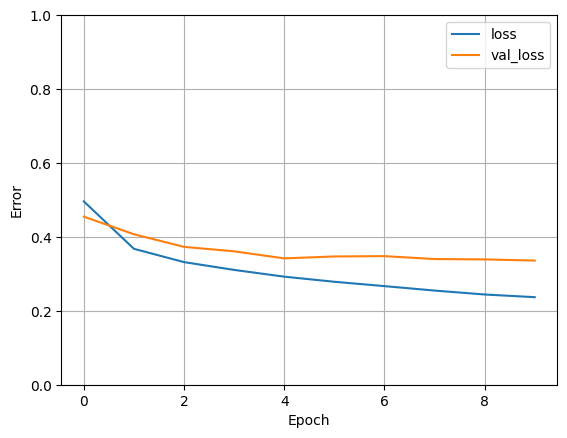

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)